## Configure environment

In [66]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint
import shutil

In [67]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [68]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [69]:
if IN_COLAB:
  if not os.path.exists("/data/video_prediction_dataset.hdf5"):
    !gdown 1fYtaFcGKSL8ykJFbewAFsFf9C4aW0DuV
    !gdown 1VILdkCRWsDTrN9DPeMLh8jlibAoBLzy-
    !gdown 197pDAI8KVsiDAA1xaPbitZpmvzh9CDqT
    !gdown 1XqgXAtxWUdnBJnvQTtEr8JpBkVi3JuSC
    !gdown 1_DVttDvwxCm_QGDxU2tbaaclWKd1VCau
    !gdown 1QkqsqjYhdJbqf2HUOQXwroYaO0uOLUPm
    !gdown 1EDwJ7Q8gznhPCiv8Vnu1UZM5nQNrZJgw
    %mkdir -p /data
    %mv /content/*.hdf5 /data/
    %mv /content/*.npy /data/
    %mv /content/*.png /data/
    %mv /content/*.h5 /data/

In [70]:
%%capture
%pip install torch torchvision h5py xarray matplotlib netcdf4 tensorflow opencv-python

In [71]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import tensorflow as tf
import cv2

if not IN_COLAB:
  sys.path.append('../common')
import common

In [72]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [73]:
if not IN_COLAB:
  common.set_memory_limit_if_not_limit(1.5)

In [74]:
os.makedirs('save', exist_ok=True)

## Load data

In [75]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')
mask_path = os.path.join(data_folder,'mask_black_skygptdata.png')
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, group=gname)

['test', 'trainval']


In [76]:
print(dss['test']['images_log'])
print(dss['test']['images_log'].shape)

<xarray.DataArray 'images_log' (phony_dim_0: 4467, phony_dim_1: 16,
                                phony_dim_2: 64, phony_dim_3: 64, phony_dim_4: 3)>
[878247936 values with dtype=uint8]
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3, phony_dim_4
(4467, 16, 64, 64, 3)


In [77]:
times_curr_train = np.load(os.path.join(data_folder,"times_curr_trainval.npy"),allow_pickle=True)
times_curr_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)

print('-'*50)
print("times_curr_train.shape:", times_curr_train.shape)
print("images_log_train.shape:", dss['trainval']['images_log'].shape)
print("images_pred_train.shape:", dss['trainval']['images_pred'].shape)
print("times_curr_test.shape:", times_curr_test.shape)
print("images_log_test.shape:", dss['test']['images_log'].shape)
print("images_pred_test.shape:", dss['test']['images_pred'].shape)
print('-'*50)

# get the input dimension for constructing the model
num_log_frame = dss['trainval']['images_log'].shape[1]
img_side_len = dss['trainval']['images_log'].shape[2]
num_color_channel = dss['trainval']['images_log'].shape[4]
num_pred_frame = dss['trainval']['images_pred'].shape[1]
image_log_dim = [num_log_frame,img_side_len,img_side_len,num_color_channel]
image_pred_dim = [num_pred_frame,img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of log frames:", num_log_frame)
print("number of pred frames:", num_pred_frame)
print("number of color channels:", num_color_channel)
print("context(log) image dimension:", image_log_dim)
print("future(pred) image dimension:", image_pred_dim)

--------------------------------------------------
times_curr_train.shape: (53336,)
images_log_train.shape: (53336, 16, 64, 64, 3)
images_pred_train.shape: (53336, 15, 64, 64, 3)
times_curr_test.shape: (4467,)
images_log_test.shape: (4467, 16, 64, 64, 3)
images_pred_test.shape: (4467, 15, 64, 64, 3)
--------------------------------------------------
image side length: 64
number of log frames: 16
number of pred frames: 15
number of color channels: 3
context(log) image dimension: [16, 64, 64, 3]
future(pred) image dimension: [15, 64, 64, 3]


# Processing data

## Black border mask

In [78]:
def get_mask_to_black(size=64):
  mask_png = np.array(PIL.Image.open(mask_path).resize((size, size)).getdata())
  # Mask for size size
  print(mask_png.shape)
  mask_to_black = (mask_png[:,3] > 127)
  not_mask_to_black = (mask_png[:,3] <= 127)
  print(mask_to_black.sum()) # alpha = 1 = black visible
  print(not_mask_to_black.sum())
  print(not_mask_to_black.sum()+mask_to_black.sum())
  mask_to_black = mask_to_black.reshape((size, size))
  empty_mask = np.ones((size, size, 3))
  mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)
  return mask_to_black

mask_to_black = get_mask_to_black(64)

(4096, 4)
1674
2422
4096


## Cloud segmenter model

In [79]:
cloud_segmenter_path = os.path.join(data_folder, "MultiUnetJoseBACKUP256weight_10_110_1_100_10.h5")
cloud_segmenter = tf.keras.models.load_model(cloud_segmenter_path)

In [80]:
im_ori = dss['trainval']['images_log'][randint(0,2000)][0].data[:,:,::-1]
print(im_ori.shape)
size = im_ori.shape
im_resized = cv2.resize(im_ori, (256, 256))
prediccion1 = np.squeeze(cloud_segmenter(np.expand_dims(im_resized, 0), training=False))
prediccion = np.argmax(prediccion1, axis=2)
pre_resized = cv2.resize(prediccion, (size[1], size[0]), interpolation=cv2.INTER_NEAREST)

(64, 64, 3)


In [81]:
cmap = mcolors.ListedColormap(['black', 'cyan', 'yellow', 'white', 'blue'], 'CloudSegmenter')

(64, 64, 3)


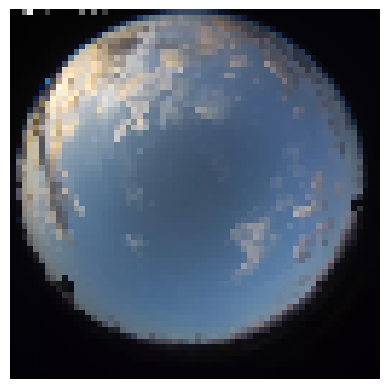

[0 1 3 4]


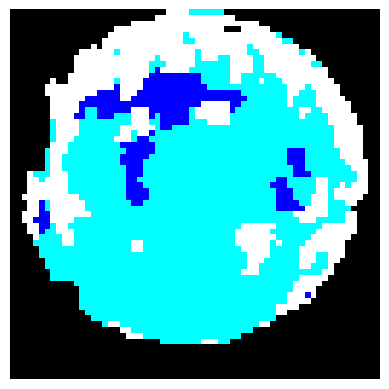

In [82]:
plt.axis('off')
print(im_ori.shape)
plt.imshow(im_ori)
plt.show()
print(np.unique(pre_resized))
plt.axis('off')
plt.imshow(pre_resized, cmap=cmap, vmin=0, vmax=5)
plt.show()

In [83]:
N_VALUES_CLOUD_MASK = 5

import gc

def segment_clouds(img):
  #tf.keras.backend.clear_session()
  #_ = gc.collect()
  img = img[:,:,::-1]
  size = img.shape
  im_resized = cv2.resize(img, (256, 256))
  pred = cloud_segmenter(np.expand_dims(im_resized, 0), training=False)
  prediccion1 = np.squeeze(pred)
  prediccion = np.argmax(prediccion1, axis=2)
  pre_resized = cv2.resize(prediccion, (size[1], size[0]), interpolation=cv2.INTER_NEAREST)
  out = np.eye(N_VALUES_CLOUD_MASK)[pre_resized]
  return out

In [84]:
def preproc_segment_clouds(batch, finalsize=64):
  ## Resized to 256 mandatory
  tf.keras.backend.clear_session()
  _ = gc.collect()
  shape = batch.shape
  batch = batch.flatten(0, 1).cpu().numpy()
  pred = np.array([cloud_segmenter(np.expand_dims(b, 0), training=False)[0].numpy() for b in batch])
  prediccion = np.argmax(pred, axis=3)
  prediccion = torch.unflatten(torch.from_numpy(prediccion), 0, shape[0:2])
  out = torch.from_numpy(np.eye(N_VALUES_CLOUD_MASK)[prediccion])
  out = torch.permute(out, (0, 1, 4, 2, 3))
  out = torch.from_numpy(np.array([transforms.functional.resize(v, finalsize).numpy() for v in out]))
  return out

In [85]:
def preproc_specific(vids):
  out = preproc_segment_clouds(vids)
  out = torch.argmax(out, dim=2)
  out = torch.from_numpy(np.eye(N_VALUES_CLOUD_MASK)[out]).bool()
  return out

### Dataloaders

In [86]:
bs = 32
transform = transforms.Compose([
  transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
  transforms.Lambda(lambda x: torch.from_numpy(cv2.resize(x[:,:,::-1], (256, 256)))),
])
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=False, device=device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=False, device=device)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)


In [87]:
def show(img):
    labels_again = torch.argmax(img, dim=1).cpu()
    f = plt.figure(figsize=(12, 12), layout='tight')
    ncols = len(img)//4 if len(img) % 4 == 0 else len(img)//4 + 1
    axarr = f.subplots(4,4)
    for i in range(len(img)):
        axarr[i//4][i%4].set_axis_off()
        axarr[i//4][i%4].imshow(labels_again[i], cmap=cmap, vmin=0, vmax=5)
    plt.show()

def show_nomask(img):
    f = plt.figure(figsize=(12, 12), layout='tight')
    axarr = f.subplots(4,4)
    for i in range(len(img)):
        axarr[i//4][i%4].set_axis_off()
        axarr[i//4][i%4].imshow(img[i])
    plt.show()

0
torch.Size([32, 16, 256, 256, 3])
torch.Size([32, 16, 5, 64, 64])
torch.Size([32, 16, 5, 64, 64])


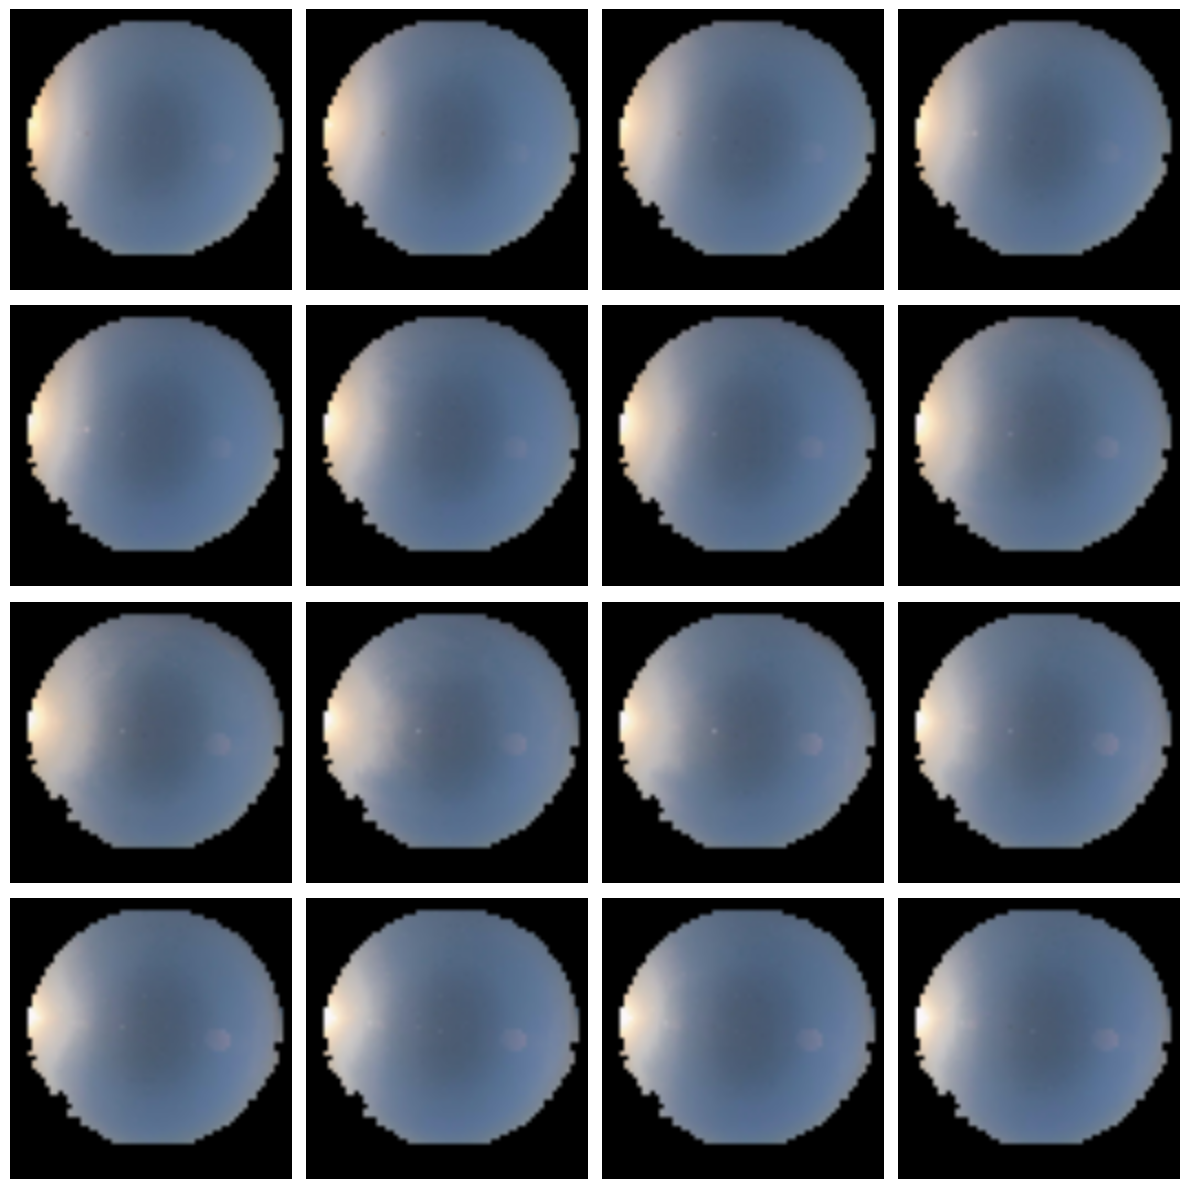

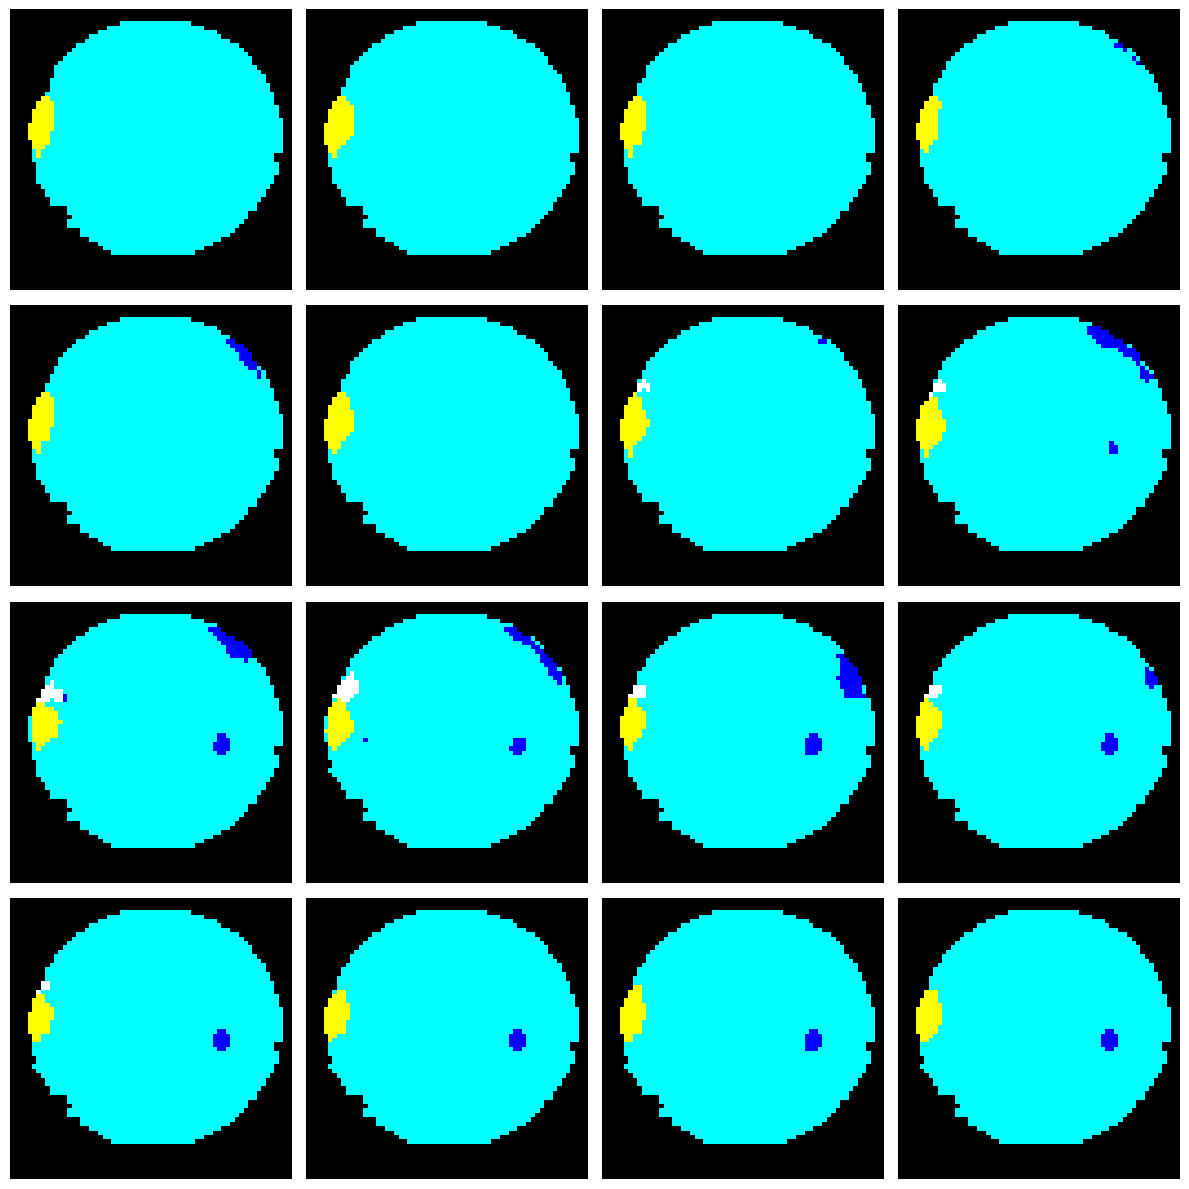

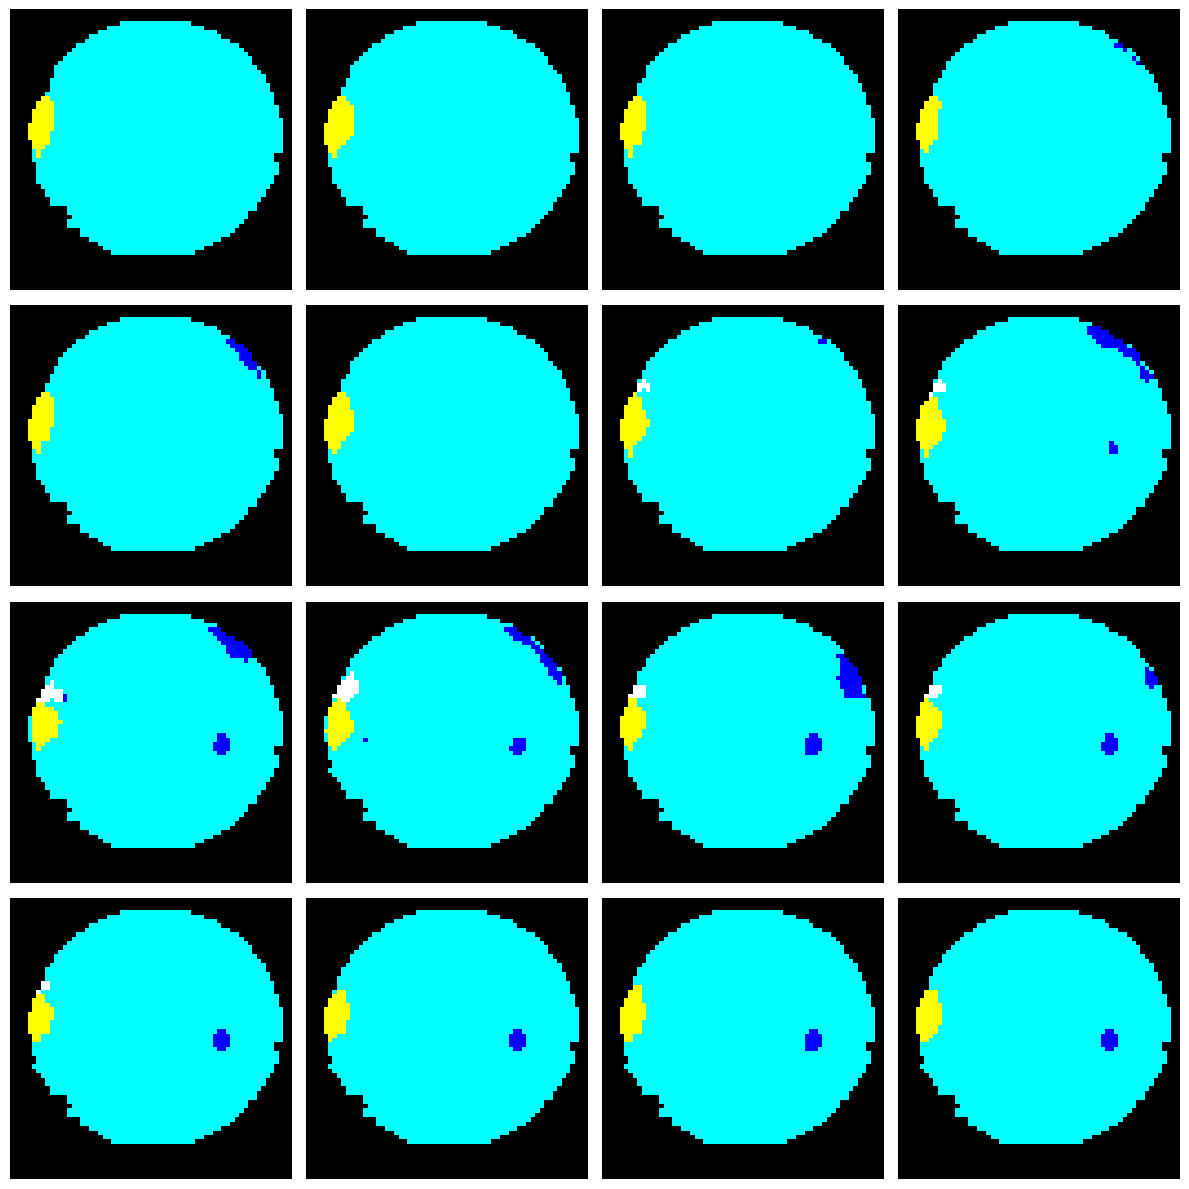

In [88]:
for idx, (videos, targets) in enumerate(train_loader):
    print(idx)
    ori = videos
    print(videos.shape)
    videos = preproc_segment_clouds(videos)
    print(videos.shape)
    videosstore = preproc_specific(ori).float()
    videosstore = torch.permute(videosstore, (0, 1, 4, 2, 3))
    print(videosstore.shape)
    show_nomask(ori[0].data.cpu())
    show(videos[0].data.cpu())
    show(videosstore[0].data.cpu())
    break

## Processing and storing

In [89]:
print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))
print(img_side_len)

53336
1667
4467
140
64


In [90]:
masked_clouds_path = os.path.join(data_folder, 'masked_clouds.hdf5')

In [91]:
def process_and_store(path: str, train_loader, test_loader, bs):
  with h5py.File(path, 'w') as f:
    train_group = f.create_group('trainval')
    images_log_dset = train_group.create_dataset('images_log', shape=(len(train_dataset), num_log_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    images_pred_dset = train_group.create_dataset('images_pred', shape=(len(train_dataset), num_pred_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    test_group = f.create_group('test')
    imagest_log_dset = test_group.create_dataset('images_log', shape=(len(test_dataset), num_log_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    imagest_pred_dset = test_group.create_dataset('images_pred', shape=(len(test_dataset), num_pred_frame, img_side_len, img_side_len/8, N_VALUES_CLOUD_MASK), dtype=np.uint8)
    for idx, (videos, targets) in enumerate(train_loader):
      mini = idx*bs
      maxi = (idx+1)*bs
      videos = preproc_specific(videos)
      images_log_dset[mini:maxi] = np.packbits(videos.cpu().numpy(), axis=3)
      targets = preproc_specific(targets)
      images_pred_dset[mini:maxi] = np.packbits(targets.cpu().numpy(), axis=3)
      if idx%10==0:
        print(f"{idx}/{len(train_loader)}")
    for idx, (videos, targets) in enumerate(test_loader):
      mini = idx*bs
      maxi = (idx+1)*bs
      videos = preproc_specific(videos)
      imagest_log_dset[mini:maxi] = np.packbits(videos.cpu().numpy(), axis=3)
      targets = preproc_specific(targets)
      imagest_pred_dset[mini:maxi] = np.packbits(targets.cpu().numpy(), axis=3)
      if idx%10==0:
        print(f"{idx}/{len(test_loader)}")

In [ ]:
drive_masked_clouds_path = os.path.join(COLAB_BASE_DIR, 'common/masked_clouds.hdf5')
if os.path.exists(drive_masked_clouds_path):
  print('Masked clouds file already exists. Copying...')
  shutil.copyfile(drive_masked_clouds_path, masked_clouds_path)
else:
  print('Masked clouds doesn\'t exist. Processing...')
  process_and_store(masked_clouds_path, train_loader, test_loader, bs)
  print('Saving in drive...')
  shutil.copyfile(masked_clouds_path, drive_masked_clouds_path)

Masked clouds doesn't exist. Processing...
0/1667
10/1667
20/1667
30/1667
40/1667
50/1667
60/1667
70/1667
80/1667
90/1667
100/1667
110/1667
120/1667


# Checking stored processed data

In [ ]:
if not os.path.exists(masked_clouds_path):
  print('Masked clouds file not available. Download it.')

with h5py.File(masked_clouds_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dsm = {}
for gname in group_names:
    dsm[gname] = xr.open_dataset(masked_clouds_path, group=gname)

In [ ]:
print(dsm['trainval']['images_log'].shape)
print(dsm['test']['images_log'].shape)

In [ ]:
bs = 32 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1))),
])
# Create Dataset and DataLoader
btrain_dataset = common.VideoDataset(dsm['trainval']['images_log'], dsm['trainval']['images_pred'], transform=transform, stack_videos=False, device=device)
btrain_loader = DataLoader(btrain_dataset, batch_size=bs, shuffle=False)


transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1))),
])
btest_dataset = common.VideoDataset(dsm['test']['images_log'], dsm['test']['images_pred'], transform=transform, stack_videos=False, device=device)
btest_loader = DataLoader(btest_dataset, batch_size=8, shuffle=False)

print(f"Number of videos: {len(btrain_dataset.videos)}.")
print(f"Number of video batches: {len(btrain_loader)}")
print(f"Size of video batches: {bs}.")

In [ ]:
bs = 32 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    transforms.Lambda(lambda x: torch.from_numpy(cv2.resize(x[:,:,::-1], (256, 256)))),
    #transforms.ToTensor(),
    #transforms.Resize(64),
    #transforms.Lambda(lambda x: x.float()),
])
# Create Dataset and DataLoader
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=False, device=device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=False, device=device)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Number of videos: {len(train_dataset.videos)}.")
print(f"Number of video batches: {len(train_loader)}")
print(f"Size of video batches: {bs}.")

In [ ]:
# Fixed input for debugging
fixed_x1, _ = next(iter(train_loader))
fixed_x2, _ = next(iter(btrain_loader))
print(fixed_x1[0].shape) # 0 because VideoDataset has batch_size videos, not images.
print(f"Number of images per video: {fixed_x1[0].shape[0]}")
print(f"Number of images per batch: {fixed_x1[0].shape[0]*bs}")
print(fixed_x2.shape)
print(fixed_x2[0].shape)
print(f"Number of images per video: {fixed_x2[0].shape[0]}")
print(f"Number of images per batch: {fixed_x2[0].shape[0]*bs}")

In [ ]:
print(fixed_x2[0][0])

In [ ]:
i = 0#random.randint(0, bs-1)
#fx2 = preproc_specific(fixed_x1)[i] #fixed_x2[i]
#fx2 = torch.permute(fx2, (0, 3, 1, 2))
show(fx2.float().cpu())
#show_nomask(fx)
print(fx2.shape)
labels_again = torch.argmax(fx2.float(), dim=1).cpu()
f = plt.figure(figsize=(12, 12), layout='tight')
axarr = f.subplots(4,4)
for i in range(4):
  for j in range(4):
    print(labels_again[4*i+j].unique())
    axarr[i][j].set_axis_off()
    axarr[i][j].imshow(labels_again[4*i+j], cmap=cmap, vmin=0, vmax=5)
plt.show()
f = plt.figure(figsize=(12, 12), layout='tight')
axarr = f.subplots(4,4)
for i in range(4):
  for j in range(4):
    axarr[i][j].set_axis_off()
    axarr[i][j].imshow(torch.permute(fixed_x1[i][4*i+j], (1,2,0)).cpu())
plt.show()